Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 

# Set Up Environment

In [2]:
# !pip install --upgrade pip
# !pip install oolearning --upgrade
# !pip install hyperopt
# !pip install bayesian-optimization
# !pip install lightgbm

In [4]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 9
plt.rcParams['figure.figsize'] = [width, width/1.333]

# Import Data

**`ExploreClassificationDataset`** is a class that gives convenience while exploring a new (classification) dataset by providing common functionality frequently needed during standard exploration.

Below, the class is initialized from a csv file (but you can also initialize from an existing pandas DataFarme using the constructor, **`ExploreClassificationDataset(dataset, target_variable)`**.

Additionally, sometimes we have a numeric target (even though the target is logically categorical), that we would like to change in order to make the outcome more specific. In this example, we load in the **`titanic`** dataset (https://www.kaggle.com/c/titanic/data), and change the target variable (**`Survived`**) from **`1`'s** & **`0`'s**, to **`lived`**/**`died`**.

In [5]:
csv_file = '../data/titanic.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

# Getting a General Understanding of the Data

In [6]:
explore.dataset.head()  # we can access the data directly by `.dataset`

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The first thing that I noticed is **`Pclass`** is imported as numeric feature, but it might be better suited as categoric, so let's convert it via **`.set_as_categoric()`**. Note that **`Pclass`** will now show up under categoric values when we do **`.categoric_summary()`**, below.

In [7]:
# Description of data says (https://www.kaggle.com/c/titanic/data):
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower

# let's convert Pclass to categoric variable
explore.set_as_categoric(feature='Pclass', mapping={1: 'Upper', 2: 'Middle', 3: 'Lower'})

Let's explore the numeric columns.

In [8]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
PassengerId,891,0,0.000,0,0.000,446.000,257.354,0.577,0.000,-1.200,1.00,90.00,223.500,446.000,668.5,802.000,891.000
Age,714,177,0.199,0,0.000,29.699,14.526,0.489,0.389,0.178,0.42,14.00,20.125,28.000,38.0,50.000,80.000
SibSp,891,0,0.000,608,0.682,0.523,1.103,2.108,3.695,17.880,0.00,0.00,0.000,0.000,1.0,1.000,8.000
Parch,891,0,0.000,678,0.761,0.382,0.806,2.112,2.749,9.778,0.00,0.00,0.000,0.000,0.0,2.000,6.000
Fare,891,0,0.000,15,0.017,32.204,49.693,1.543,4.787,33.398,0.00,7.55,7.910,14.454,31.0,77.958,512.329


A couple of things we might note, for example:

    A) `Age` has missing values.
    B) `Fare` has `15` zeros, which we might assume is equivalent to a missing/null value. (Tickets probably weren't free.)
    C) `PassengerId` will not be helpful.

Now let's explore the categoric columns.

In [9]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
Survived,891,0,0.000,died,2,0.002
Pclass,891,0,0.000,Lower,3,0.003
Name,891,0,0.000,"van Melkebeke, Mr. Philemon",891,1.000
Sex,891,0,0.000,male,2,0.002
Ticket,891,0,0.000,CA. 2343,681,0.764
Cabin,204,687,0.771,B96 B98,147,0.721
Embarked,889,2,0.002,S,3,0.003


For these columns, I might note, for example, that `Name`, `Ticket`, and `Cabin` all have a very high number of unique values (`Cabin` also have a high number of null values). This obviously make sense, but also means we might not want to use these columns.

_(Note: in https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html, the author describes how he cleverly extracts the title associated with the name, where applicable. That is a great idea, but outside the scope of this demo.)_

In [10]:
explore.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])  # drop/remove specific columns

In [11]:
explore.dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,died,Lower,male,22.0,1,0,7.2500,S
1,lived,Upper,female,38.0,1,0,71.2833,C
2,lived,Lower,female,26.0,0,0,7.9250,S
3,lived,Upper,female,35.0,1,0,53.1000,S
4,died,Lower,male,35.0,0,0,8.0500,S


Also, the `__str__` function is implemented in this class so we can simply print it out to get a quick view of the numeric and categoric summaries.

In [12]:
print(explore)

Target Variable: Survived

Numeric Summary
       count  nulls  perc_nulls  num_zeros  perc_zeros    mean  st_dev  coef of var  skewness  kurtosis   min    10%     25%     50%   75%     90%      max
Age    714    177    0.199       0          0.000       29.699  14.526  0.489        0.389     0.178     0.42  14.00  20.125  28.000  38.0  50.000  80.000 
SibSp  891    0      0.000       608        0.682       0.523   1.103   2.108        3.695     17.880    0.00  0.00   0.000   0.000   1.0   1.000   8.000  
Parch  891    0      0.000       678        0.761       0.382   0.806   2.112        2.749     9.778     0.00  0.00   0.000   0.000   0.0   2.000   6.000  
Fare   891    0      0.000       15         0.017       32.204  49.693  1.543        4.787     33.398    0.00  7.55   7.910   14.454  31.0  77.958  512.329


Categoric Summary
          count  nulls  perc_nulls    top  unique  perc_unique
Survived  891    0      0.000       died   2       0.002      
Pclass    891    0      0.000  

# Diving In

## Numeric Features

Let's dive in a little more into the characteristics of our numeric features.

### Correlations

A good place to start is with an overall idea of how correlated our numeric features are.

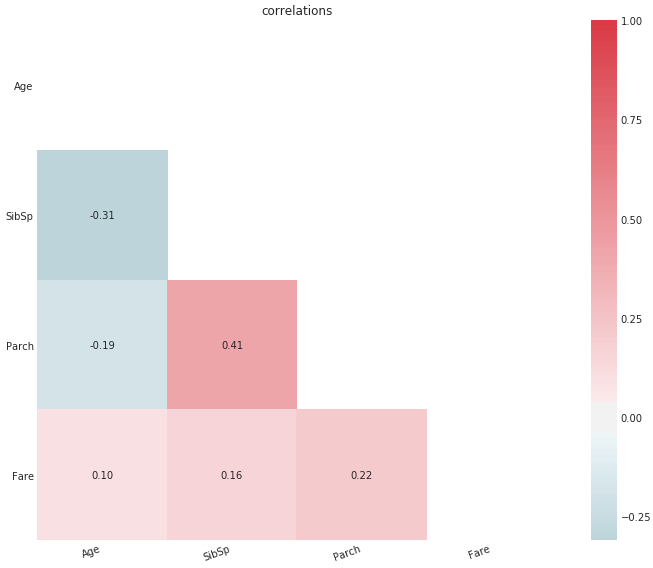

In [13]:
explore.plot_correlation_heatmap()

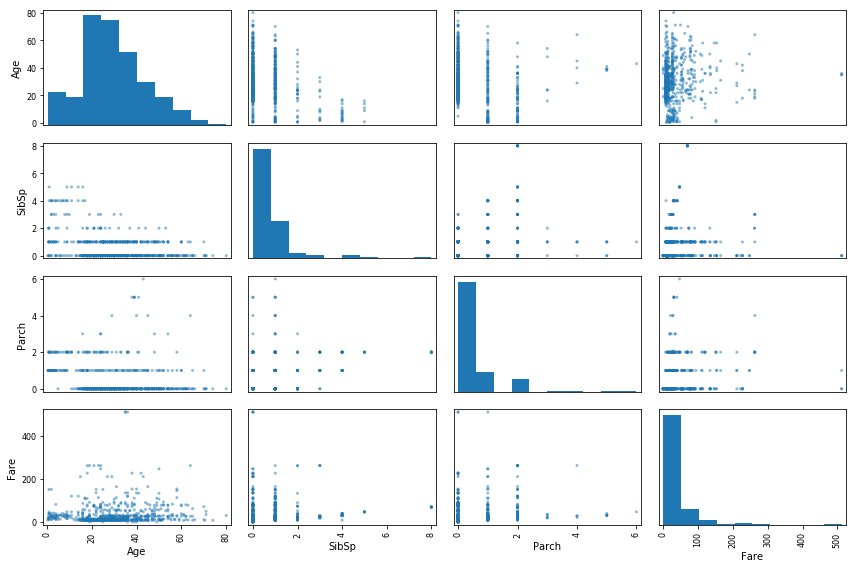

In [14]:
explore.plot_scatterplot_numerics()

### Features

Now let's take a look at each numeric feature, by itself, as well as how it relates to our target variable.

#### Age

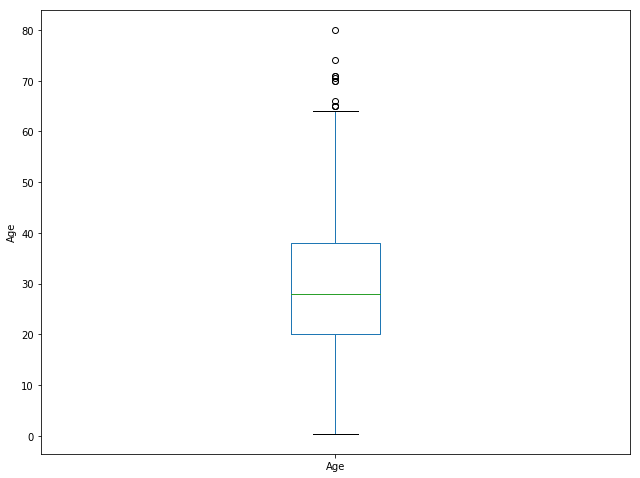

In [15]:
explore.plot_boxplot(numeric_feature='Age')

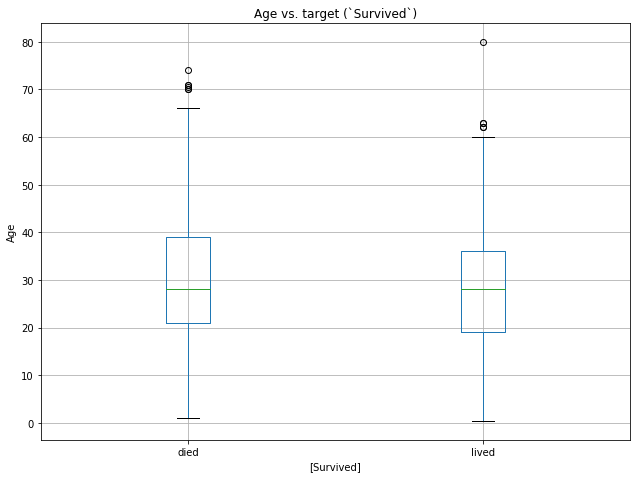

In [16]:
explore.plot_against_target(feature='Age')

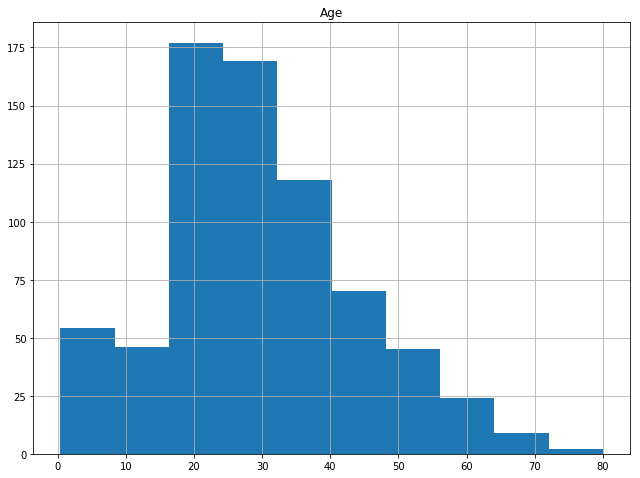

In [18]:
explore.plot_histogram(numeric_feature='Age')

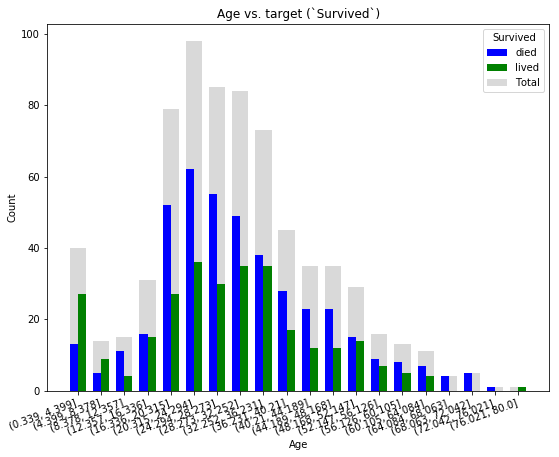

In [19]:
explore.plot_histogram_against_target(numeric_feature='Age')

#### SibSp

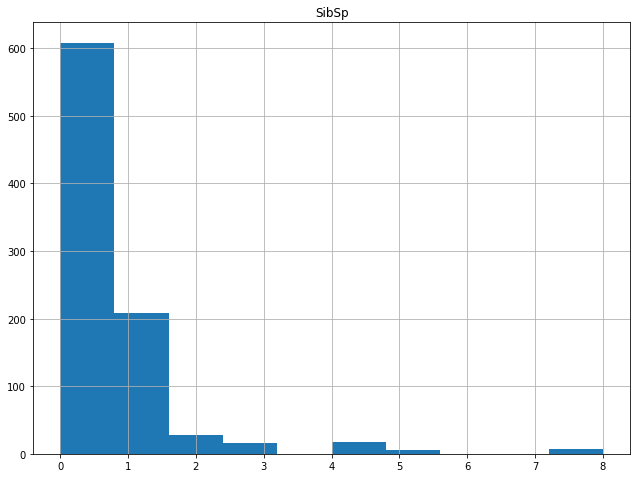

In [20]:
explore.plot_histogram(numeric_feature='SibSp')

#### Parch

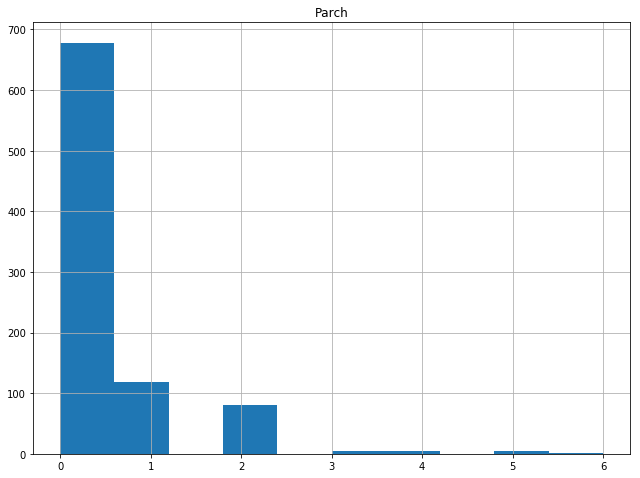

In [21]:
explore.plot_histogram(numeric_feature='Parch')

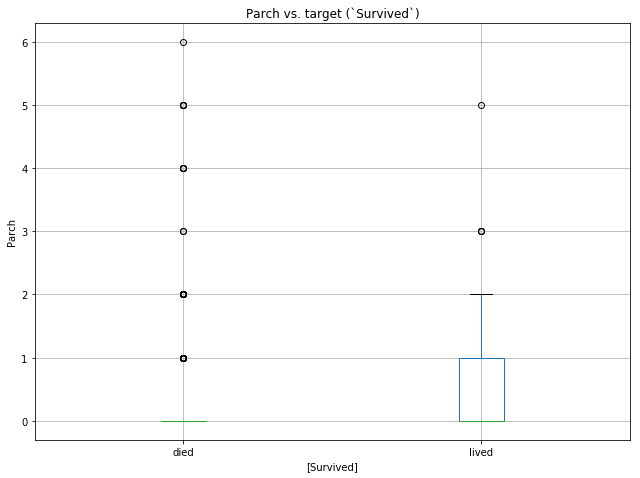

In [22]:
explore.plot_against_target(feature='Parch')

Above, we saw there was moderate correlation of **`Parch`** and  **`SibSp`**, let's look at a scatter plot to see if it shows anything useful.

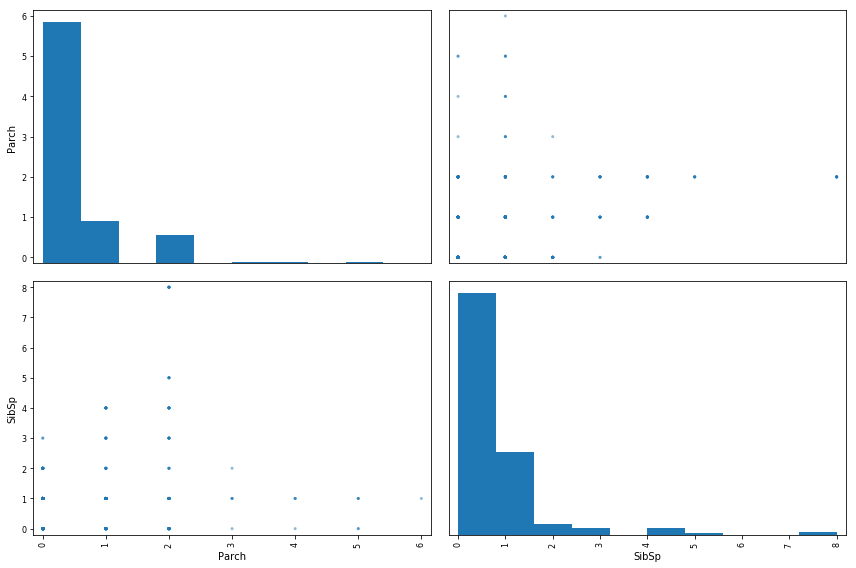

In [23]:
explore.plot_scatterplot_numerics(numeric_columns=['Parch', 'SibSp'])

#### Fare

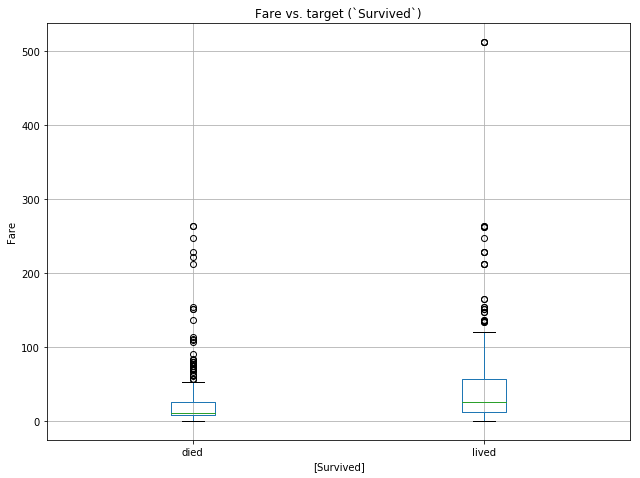

In [24]:
explore.plot_against_target(feature='Fare')

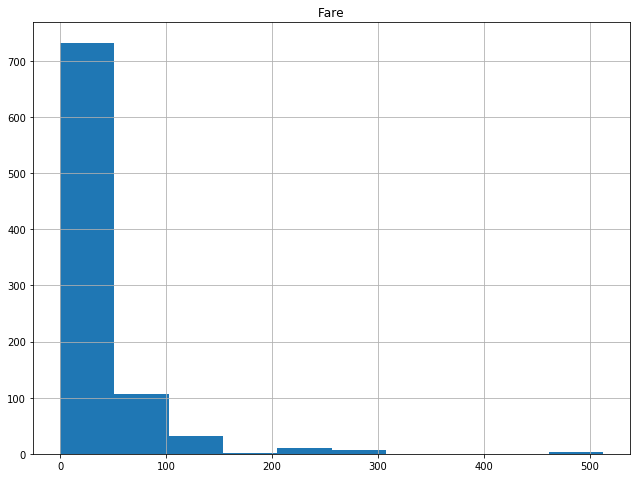

In [25]:
explore.plot_histogram(numeric_feature='Fare')

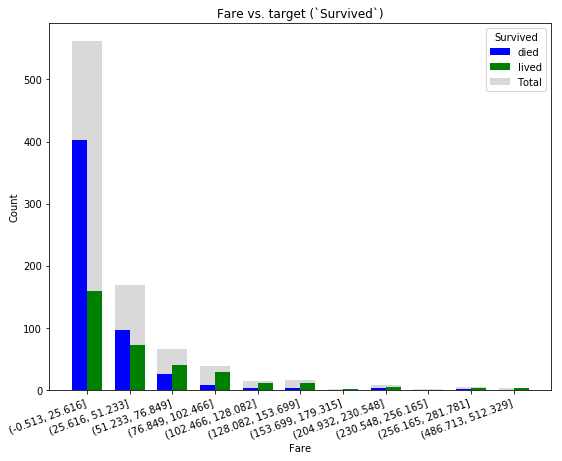

In [26]:
explore.plot_histogram_against_target(numeric_feature='Fare')

## Categoric Features

Let's dive in a little more into the characteristics of our categoric features.

#### Pclass

We can see the unique values (and correspond frequencies) for a given feature via **`.unique_values()`**:

In [27]:
explore.unique_values(categoric_feature='Pclass')

,freq,perc
Lower,491,0.551
Upper,216,0.242
Middle,184,0.207


Or we can visualize it via **`.plot_unique_values()`**:

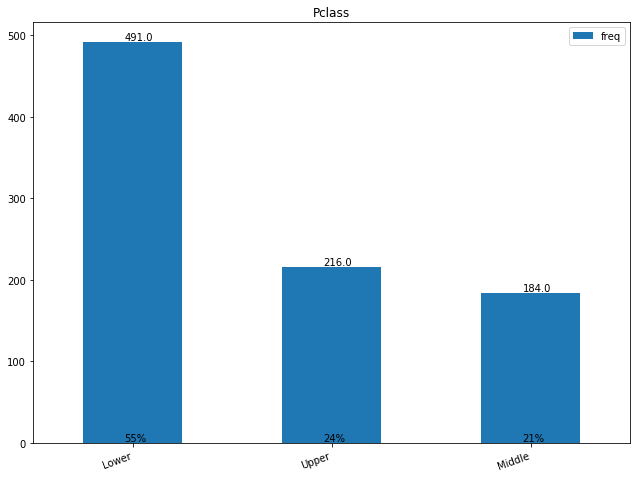

In [28]:
explore.plot_unique_values(categoric_feature='Pclass')

Often, a categoric feature has inherent order. With `Pclass`, for example, we can think of the order as: `Lower < Middle < Upper`.

In this case, it would be convenient to see the data in that order.


Using the **`sort_by_feature`** parameter in the `.unique_values()` method, we can order by feature.

In [29]:
explore.unique_values(categoric_feature='Pclass', sort_by_feature=True)

,freq,perc
Upper,216,0.242
Middle,184,0.207
Lower,491,0.551


But this didn't do **exactly** what we want. It is in order, but is sorting in (reverse) alphabetical order. It's not sorting by what we think of as the logical order of `Pclass`, because we haven't specified any order.

But we can do this for categoric fatures via **`.set_level_order()`**:

In [30]:
# now set the order of categorical
explore.set_level_order(categoric_feature='Pclass',
                        levels=['Lower', 'Middle', 'Upper'])

In [31]:
explore.unique_values(categoric_feature='Pclass', sort_by_feature=True)

,freq,perc
Lower,491,0.551
Middle,184,0.207
Upper,216,0.242


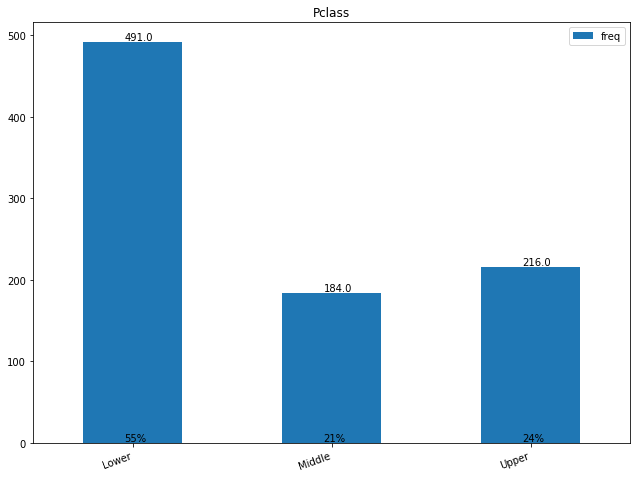

In [32]:
explore.plot_unique_values(categoric_feature='Pclass', sort_by_feature=True)

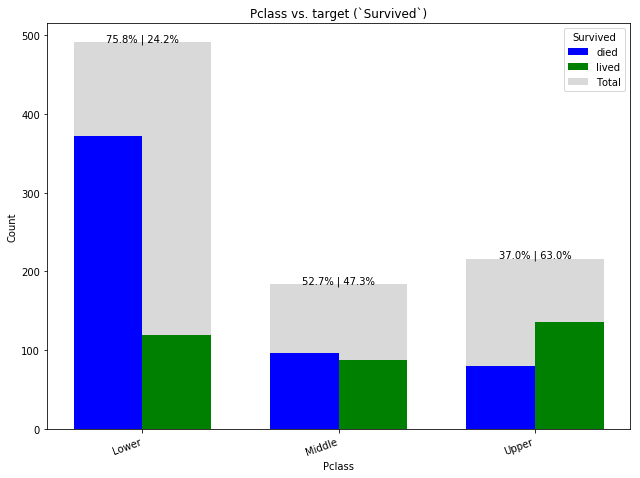

In [33]:
explore.plot_against_target(feature='Pclass')

#### Sex

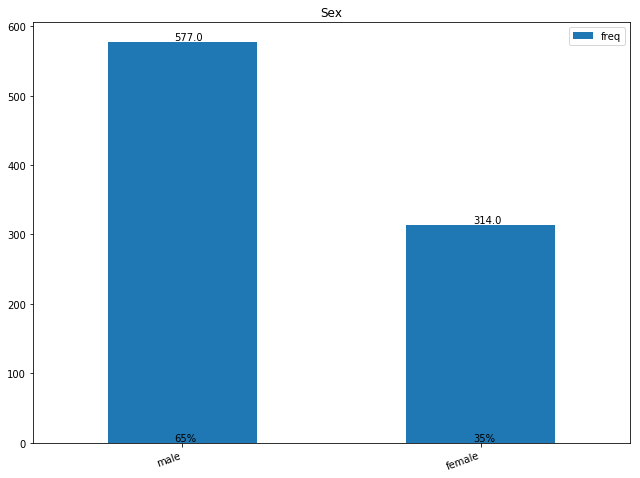

In [34]:
explore.plot_unique_values(categoric_feature='Sex')

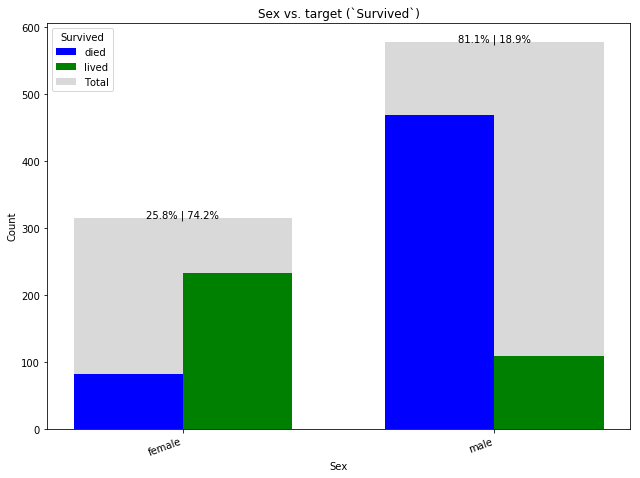

In [118]:
explore.plot_against_target(feature='Sex')

#### Embarked

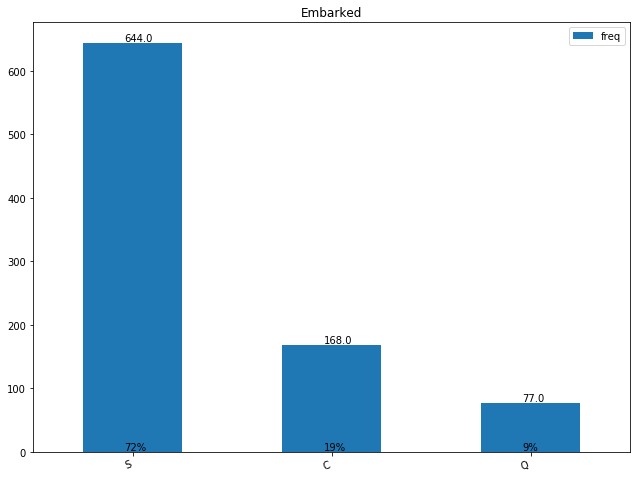

In [119]:
explore.plot_unique_values(categoric_feature='Embarked')

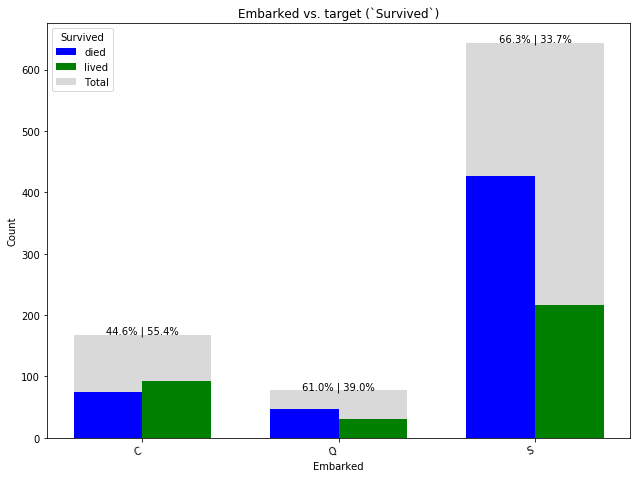

In [120]:
explore.plot_against_target(feature='Embarked')